2021-2-23 by Xuan

# Global Functions

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
import re

# to make this notebook's output stable across runs
np.random.seed(10086)

def check_data_balance(series, style="seaborn-v0_8-pastel"): # Change style to "seaborn-v0_8-pastel"
    with plt.style.context(style):
        unique = series.value_counts()
        display(unique) #show unique value counts of the target
        plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%'); #plot a pie chart for the target to see if data are balanced
from functools import wraps
import inspect
def initializer(func): #https://stackoverflow.com/questions/1389180/automatically-initialize-instance-variables
    names, varargs, keywords, defaults = inspect.getfullargspec(func)[:4]
    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)
    return wrapper

# Goal

Q1. Build a classification model for the default of credit card clients dataset. More info here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

- Explore the data
- Make sure you build a full data pipeline
- Do you require any data pre-processing? Are all the features useful? (Use only raw features)
- set the random seed to 123 (For splitting or any other random algorithm)
- Split data into training (80%) and testing (20%)
- Follow similar procedure as the one for week 2 (End-to-end Machine Learning Project). Remember apendix B
- Study the ROC Curve, decide threshold
- Use 2 classifiers.
    - Random Forest
        - tune only: n_estimators: {3, 4, 6, 7, 10, 20, 50, 100}
    - KNN Classfier
        - tune only: n_neighbors: {3, 4, 5, 7, 10, 20, 50}
    - Which one performs better in the cross validation?
    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

- Cross-validation with 4-folds.

- Other paramenters -> Use default

Notes:
  - Make your code modular, the second part of the assignmet you will have to repeat.
  - Include documentation for your code

# Data Information

This research aimed at the case of customersâ€™ default payments in Taiwan and compares the predictive accuracy of
probability of default among six data mining methods. From the perspective of risk management, the result of
predictive accuracy of the estimated probability of default will be more valuable than the binary result of
classification - credible or not credible clients. Because the real probability of default is unknown, this study
presented the novel â€œSorting Smoothing Methodâ€ to estimate the real probability of default. With the real
probability of default as the response variable (Y), and the predictive probability of default as the independent
variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by
artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to
zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural
network is the only one that can accurately estimate the real probability of default.


# Attribute Information

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable.
This study reviewed the literature and used the following 23 variables as explanatory variables:
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her
family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.
"""

# Load Data

In [2]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", skiprows=1, header=0, index_col=0)
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


# Data Exploration

## Check for missing data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_AMT4  

## Is it a balanced dataset?

,count
default payment next month,
0,23364
1,6636


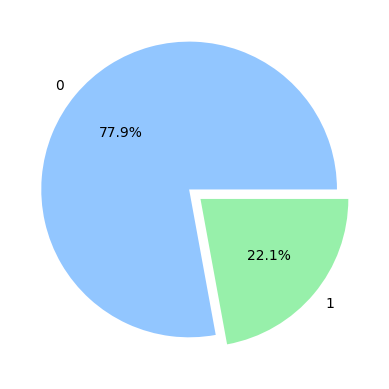

In [13]:
check_data_balance(df["default payment next month"])

## Histograms

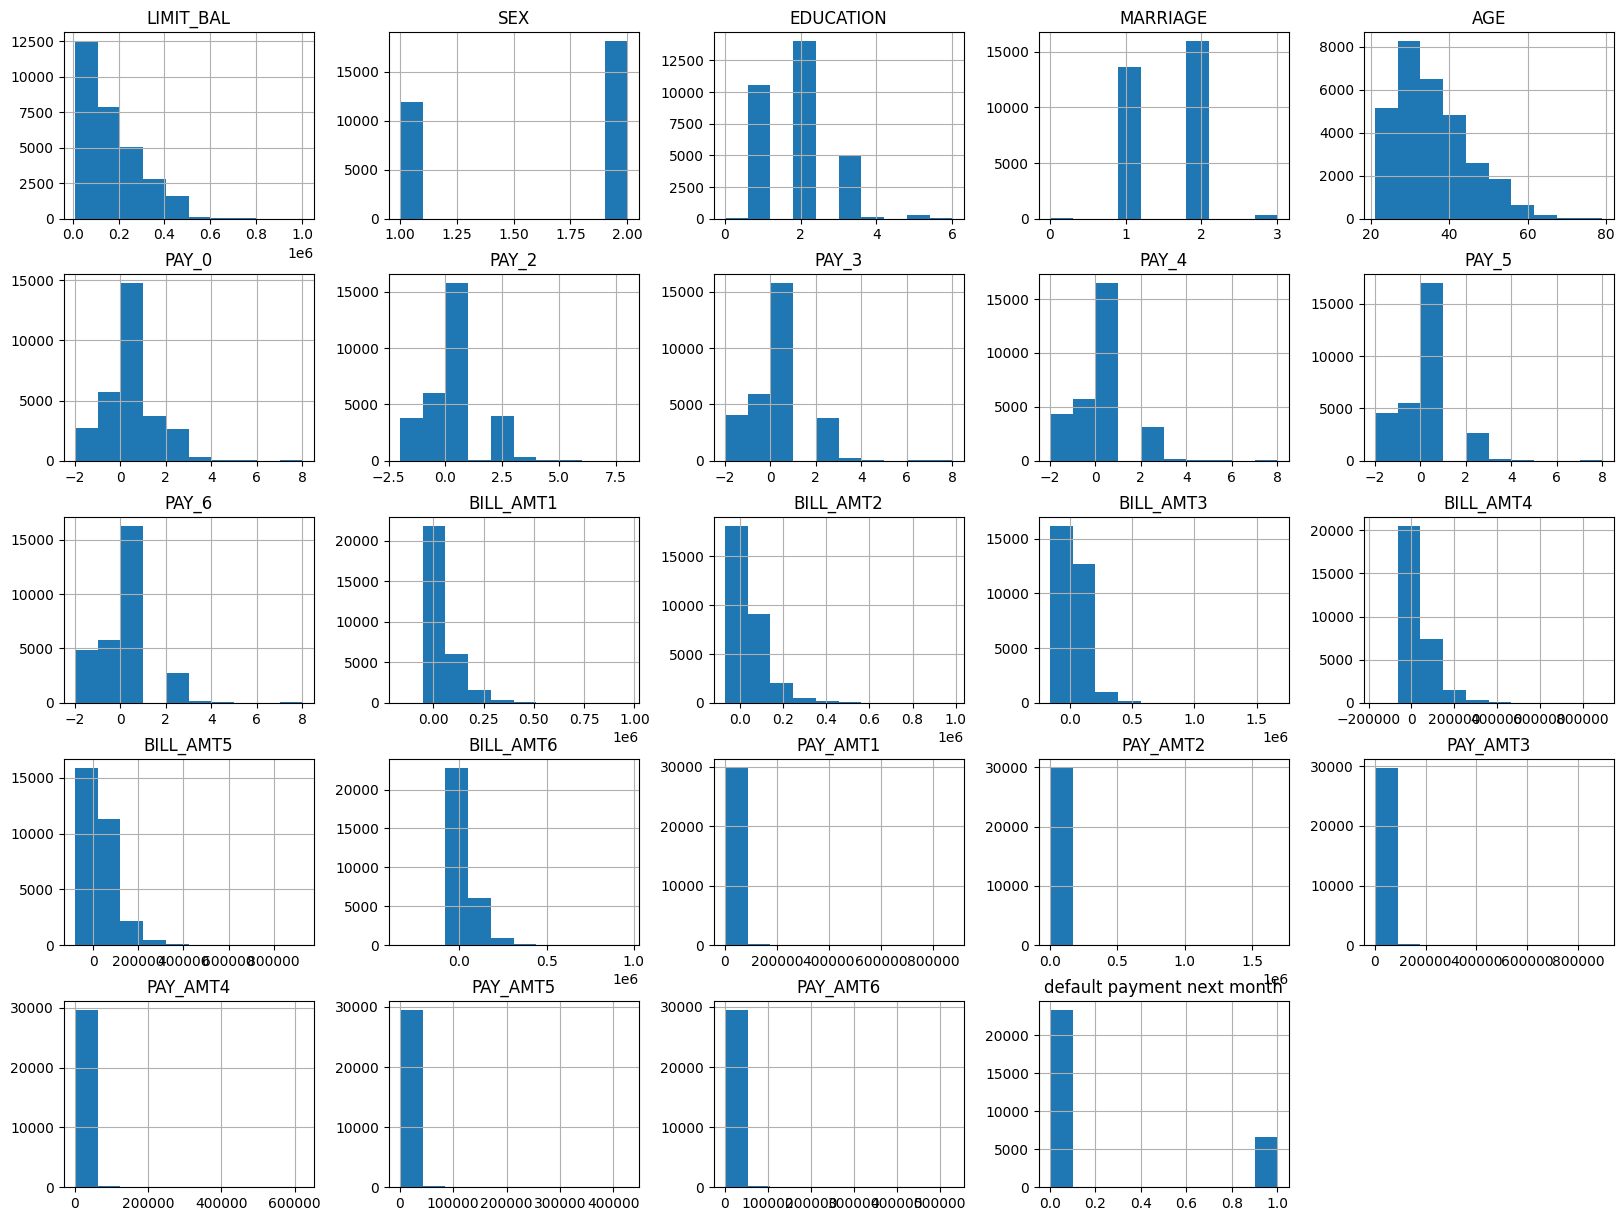

In [14]:
_ = df.hist(figsize=(20,15))

## Pair plot

In [ ]:
# this chart takes a long time.
#sns.pairplot(df.sample(1000, random_state=10086), hue="default payment next month")

# Machine Learning

## Choose X and y

In [25]:
TARGET = "default payment next month"
columns_predictors = [col for col in df.columns if col not in [TARGET]]
columns_categorical = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: default payment next month
columns_predictors: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
columns_categorical: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [26]:
X = df[columns_predictors]
y = df[TARGET]
display(X)
display(y)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100


,default payment next month
ID,
1,1
2,1
3,0
4,0
5,0
...,...
29996,0
29997,0
29998,1


## Train-test split

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10086, stratify=y) #stratified sampling based on the target
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (22500, 23)
X_test.shape: (7500, 23)
y_train.shape: (22500,)
y_test.shape: (7500,)


In [28]:
display(X_train)
display(y_train)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
17778,70000,2,3,2,55,0,0,0,0,0,...,6703,7853,7316,7350,1100,1123,1273,407,300,300
11181,190000,2,2,1,45,2,0,0,0,0,...,131132,96083,97453,99426,6800,7000,3585,3700,3754,7900
18834,70000,2,2,2,24,0,0,0,0,0,...,26194,27454,28159,25775,1800,2000,2000,1500,1500,0
19424,150000,2,1,2,31,0,0,0,-1,0,...,6221,4711,6711,6711,6000,3039,9050,2000,0,4000
15760,130000,2,2,2,22,2,2,2,2,0,...,21213,15443,25371,4264,3412,1700,0,15571,4264,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14526,180000,1,2,2,43,0,0,0,0,0,...,171820,160018,164717,151235,7500,5900,6000,7000,7000,5000
21159,180000,1,2,2,39,0,0,0,0,0,...,124553,127096,128992,131660,4500,6000,6100,5500,4900,5500
15009,30000,1,3,1,43,1,3,2,2,2,...,21207,23491,22818,24321,0,0,2645,0,2029,1027


,default payment next month
ID,
17778,0
11181,0
18834,0
19424,0
15760,0
...,...
14526,0
21159,0
15009,1


,count
default payment next month,
0,17523
1,4977


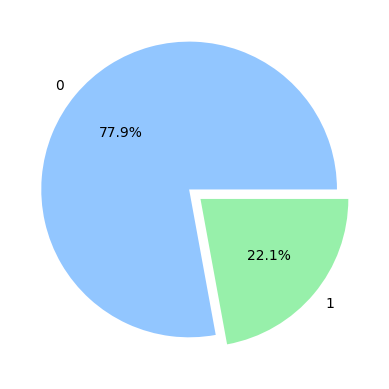

In [29]:
check_data_balance(y_train)

,count
default payment next month,
0,5841
1,1659


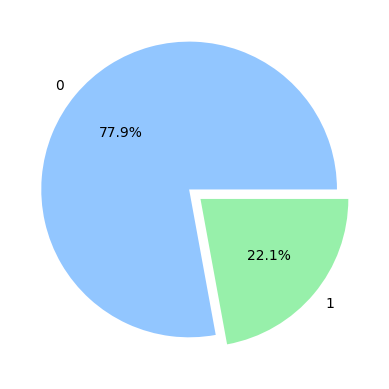

In [30]:
check_data_balance(y_test)

## Preprocessing with pipelines 🚀

### Define the pipeline(s)

In [48]:
from sklearn.pipeline import Pipeline #each pipeline can have multiple steps
from sklearn.base import BaseEstimator, TransformerMixin #classes to inherit from when building custom transformers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures #specific transformations we want to use in our pipelines

class CustomScaler(BaseEstimator, TransformerMixin):
  def __init__(self, **kwargs):
    self.scaler = MinMaxScaler(**kwargs)
  def fit(self, X, y=None):
    self.scaler.fit(X)
    return self
  def transform(self, X, y=None):
    return pd.DataFrame(self.scaler.transform(X), columns=X.columns, index=X.index)

class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, columns=[], sparse=False, output_dtype="bool", **kwargs):
    self.encoder = OneHotEncoder(sparse_output=False, dtype=output_dtype, **kwargs)
    self.columns = columns
  def fit(self, X, y=None):
    if len(self.columns) > 0:
      self.encoder.fit(X[self.columns])
    return self
  def transform(self, X, y=None):
    if len(self.columns) > 0:
      df_onehot = pd.DataFrame(self.encoder.transform(X[self.columns]), columns=self.encoder.get_feature_names_out(self.columns), index=X.index)
      return pd.concat([X.drop(self.columns, axis=1), df_onehot], axis=1)
    else:
      return X

class CustomPolynomial(BaseEstimator, TransformerMixin):
  @initializer
  def __init__(self, degree=2, interaction_only=False, include_bias=False, avoid_onehot_nonsense=False, onehot_dtype="bool", **kwargs):
    self.poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=include_bias, **kwargs)
  def fit(self, X, y=None):
    self.poly.fit(X)
    return self
  def transform(self, X, y=None):
    df_poly = pd.DataFrame(data=self.poly.transform(X), columns=self.poly.get_feature_names_out(X.columns), index=X.index)
    if self.avoid_onehot_nonsense: #one-hot dummy variables squared are still the same values, so discard those
      df_poly.drop(df_poly.filter(regex="({})\^\d+$".format("|".join(X.select_dtypes(self.onehot_dtype).columns))).columns, axis=1, inplace=True)
    return pd.concat([X, df_poly[[col for col in df_poly.columns if col not in X.columns]]], axis=1)

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    @initializer
    def __init__(self, quantile=0.5, threshold=0, frac=1):
        self.tree = ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=10086)
    def fit(self, X, y):
        self.tree.fit(X.sample(frac=self.frac, random_state=10086), y.sample(frac=self.frac, random_state=10086))
        return self
    def transform(self, X, y=None):
        return X.iloc[:, (self.tree.feature_importances_>=np.quantile(self.tree.feature_importances_, self.quantile)) & (self.tree.feature_importances_>=self.threshold)]

pipeline_full = Pipeline([
  ("onehot", CustomOneHotEncoder(columns=columns_categorical)),
  ("poly", CustomPolynomial(avoid_onehot_nonsense=True)),
  ("scaler", CustomScaler(feature_range=(0,1))),
  ("select", CustomFeatureSelector(quantile=0.5, threshold=0.001, frac=0.1)),
])

In [49]:
X_train[columns_categorical]

,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,,,,
17778,2,3,2,0,0,0,0,0,0
11181,2,2,1,2,0,0,0,0,0
18834,2,2,2,0,0,0,0,0,0
19424,2,1,2,0,0,0,-1,0,0
15760,2,2,2,2,2,2,2,0,0
...,...,...,...,...,...,...,...,...,...
14526,1,2,2,0,0,0,0,0,0
21159,1,2,2,0,0,0,0,0,0
15009,1,3,1,1,3,2,2,2,2


In [50]:
# testing
pipeline_full.fit_transform(X_train, y_train)
# pipeline_full.fit_transform(X_train, y_train).info()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_2_2 PAY_6_0,PAY_2_2 PAY_6_2,PAY_3_2 PAY_4_2,PAY_3_2 PAY_5_2,PAY_3_2 PAY_6_2,PAY_4_0 PAY_6_0,PAY_4_2 PAY_5_0,PAY_4_2 PAY_5_2,PAY_4_2 PAY_6_0,PAY_5_2 PAY_6_2
ID,,,,,,,,,,,,,,,,,,,,,
17778,0.075949,0.629630,0.186590,0.101785,0.161967,0.202828,0.097969,0.333754,0.001259,0.000915,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11181,0.227848,0.444444,0.335282,0.266927,0.284878,0.303448,0.197582,0.422327,0.007784,0.005705,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18834,0.075949,0.055556,0.218964,0.161298,0.181220,0.225182,0.121004,0.351478,0.002061,0.001630,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19424,0.177215,0.185185,0.193291,0.103293,0.161491,0.199245,0.097301,0.333139,0.006869,0.002477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15760,0.151899,0.018519,0.214281,0.131639,0.176300,0.211484,0.117922,0.330785,0.003906,0.001385,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14526,0.215190,0.407407,0.361469,0.322187,0.325069,0.376362,0.271917,0.472165,0.008586,0.004808,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21159,0.215190,0.333333,0.312415,0.256654,0.278379,0.338817,0.232437,0.453335,0.005151,0.004890,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15009,0.025316,0.407407,0.206132,0.123590,0.176294,0.220662,0.115101,0.350079,0.000000,0.000000,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


### Apply the pipeline

The correct way to do it is to fit the pipeline on X_train once, and then use the fitted pipeline to transform both X_train and X_test.

NOTE: <font color="red">Do not fit the pipeline on X_test because you will leak information about the test set!!!!</font>

In [51]:
pipeline_full.fit(X_train, y_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


X_train_transformed.shape: (22500, 386)
X_test_transformed.shape: (7500, 386)


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


#### FAQ: How to access attributes within the pipelines?

In [52]:
pipeline_full["onehot"]

AttributeError: 'CustomOneHotEncoder' object has no attribute 'output_dtype'

AttributeError: 'CustomOneHotEncoder' object has no attribute 'output_dtype'

AttributeError: 'CustomOneHotEncoder' object has no attribute 'output_dtype'

In [ ]:
pipeline_full["onehot"].columns

In [ ]:
pipeline_full["onehot"].encoder.get_feature_names(pipeline_full["onehot"].columns)

## Train an ML model on the transformed training set

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1, random_state=10086)
model.fit(X_train_transformed, y_train)

## Evaluate the model on the transformed testing set

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_test_transformed)
y_pred_proba = model.predict_proba(X_test_transformed) #to calculate ROC_AUC, we need model.predict_proba() instead of model.pred()

print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"precision_score: {precision_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
print(f"f1_score: {f1_score(y_test, y_pred)}")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_proba[:,1])}")